## Solver

(m,n)=(1,1)
  ω_inertial ≈ 1.56165
  B0=  0.01 -> ω_MC ≈ 1.56229
  B0=  0.05 -> ω_MC ≈ 1.57730
  ...
  B0=     9 -> ω_MC ≈ 29.06594
  B0=    10 -> ω_MC ≈ 32.20646
  ω_MC min/max ≈ 1.56229 / 32.20646


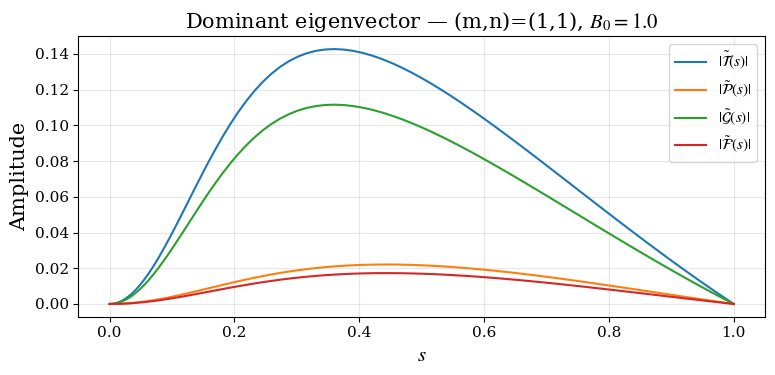

(m,n)=(1,2)
  ω_inertial ≈ 1.86492
  B0=  0.01 -> ω_MC ≈ 1.86703
  B0=  0.05 -> ω_MC ≈ 1.91642
  ...
  B0=     9 -> ω_MC ≈ 57.48882
  B0=    10 -> ω_MC ≈ 63.77123
  ω_MC min/max ≈ 1.86703 / 63.77123


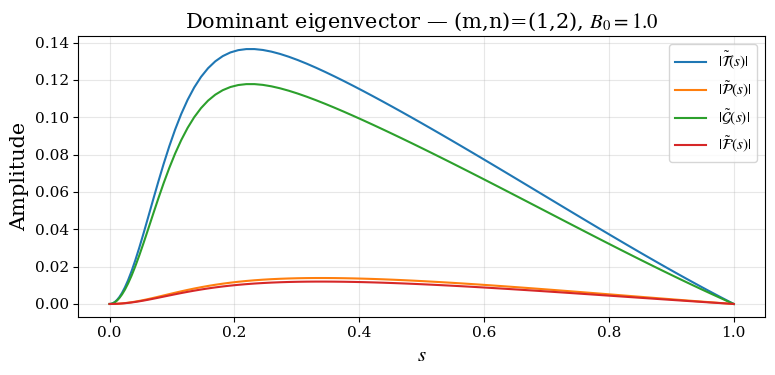

(m,n)=(3,2)
  ω_inertial ≈ 1.52929
  B0=  0.01 -> ω_MC ≈ 1.53187
  B0=  0.05 -> ω_MC ≈ 1.59131
  ...
  B0=     9 -> ω_MC ≈ 57.31848
  B0=    10 -> ω_MC ≈ 63.60115
  ω_MC min/max ≈ 1.53187 / 63.60115


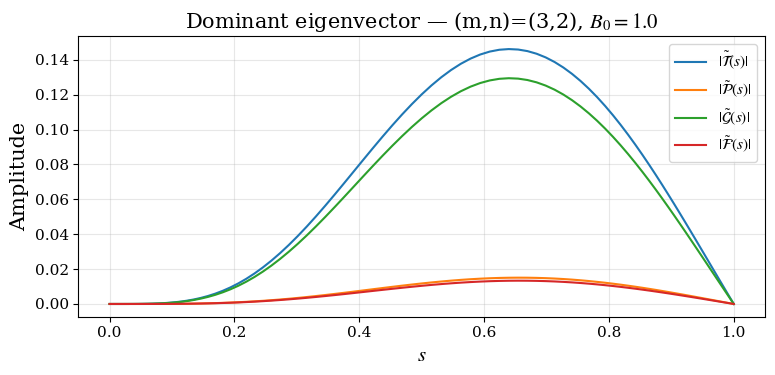

In [38]:
# === USEFUL PACKAGES ===
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.linalg import eig
from scipy.special import yv, jv, jvp
from scipy.optimize import root_scalar
from itertools import cycle
from matplotlib.ticker import LogLocator, NullFormatter
from mpl_toolkits.mplot3d import Axes3D

# === PHYSICAL PARAMETERS ===
h = 1  # Cylinder height
a = 1  # Cylinder radius

Omega_mass = 1
Omega_rot = 1
B0_values = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,
             1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,3,4,5,6,7,8,9,10]

mu0 = 1  # Permeability of free space
rho = 1  # Fluid density
C = 1

times = [1]
phi_indices = [0]

N = 100

# === CHEBYSHEV MATRIX ===
def cheb_diff(N, a):
    if N == 0:
        return np.array([[0]]), np.array([1])
    x = -np.cos(np.pi * np.arange(N + 1) / N) 
    c = np.ones(N + 1)
    c[0], c[-1] = 2, 2
    c *= (-1) ** np.arange(N + 1)
    X = np.tile(x, (N + 1, 1)).T
    dX = X - X.T + np.eye(N + 1)
    D = (np.outer(c, 1 / c)) / dX
    D -= np.diag(np.sum(D, axis=1))
    s = 0.5 * (x + 1)
    return 2 * D, s
D, s = cheb_diff(N, a)

# === Greenspan (inertial waves) ===
def inertial_frequency(m, n_axial, h, a):
    def equation(xi):
        Jm = jv(abs(m), xi)
        dJm_dxi = jvp(abs(m), xi, n=1)
        factor = np.sqrt(1 + (xi**2 * h**2) / (n_axial**2 * np.pi**2 * a**2))
        return xi * dJm_dxi + m * factor * Jm

    xi_vals = np.linspace(1e-4, 200, 1000)
    f_vals = [equation(xi) for xi in xi_vals]

    roots = []
    for i in range(len(xi_vals) - 1):
        if f_vals[i] * f_vals[i+1] < 0:
            try:
                sol = root_scalar(equation, bracket=[xi_vals[i], xi_vals[i+1]], method='brentq')
                roots.append(sol.root)
            except:
                pass
    roots = roots[:50]

    def lambda_knm(xi):
        return 2 / np.sqrt(1 + (xi**2 * h**2) / (n_axial**2 * np.pi**2 * a**2))
    lambdas = [lambda_knm(xi) for xi in roots]
    if len(lambdas) == 0:
        return np.nan
    return lambdas[0]  # dominant inertial mode

def MC_solve(m, n_axial, B0_values, N, return_evec=True):
    # Discretization
    D, s = cheb_diff(N, a)
    D2 = D @ D
    n_p = N + 1
    size = 4 * n_p

    T_idx = np.arange(0, n_p)
    P_idx = np.arange(n_p, 2 * n_p)
    G_idx = np.arange(2 * n_p, 3 * n_p)
    F_idx = np.arange(3 * n_p, 4 * n_p)

    k = (n_axial * np.pi) / h

    eig_val = []
    omega_alfven = []
    Le = []

    def compute_F1_dF1_G1(m, k, C):
        F1 = ((-1j*C*k)/2*(k**2 + m**2)) * (yv(m + 1, -1j * k) - yv(m - 1, -1j * k))
        dF1 = F1 - C * yv(m, -1j * k)
        G1 = 0
        return F1, dF1, G1
    F1_val, dF1_val, G1_val = compute_F1_dF1_G1(m, k, C)

    # === RESOLUTION ON B0 AND STORE A VALUE ===
    target_B0 = 1.0  # For Le = 1
    store_evec = bool(return_evec)
    evec_dom = None
    omega_dom = None
    stored_B0 = None

    eig_val = []
    omega_dom_series = []

    for B0 in B0_values:
        v = B0 / np.sqrt(mu0 * rho)
        omega_alfven.append(k * v)
        Le.append(v/(Omega_mass*h))

        # A and Bm for B0
        A = np.zeros((size, size), dtype=complex)
        Bm = np.zeros((size, size), dtype=complex)
        for j, sj in enumerate(s):
            # Eq 1
            row = j
            A[row, P_idx[j]] = -2j * Omega_rot * (k**3 * sj**2 + k * m**2)
            A[row, G_idx[j]] = -1j * B0 / (mu0 * rho) * (k**3 * sj**2 + k * m**2)
            A[row, F_idx[j]] = -2j * B0 / (mu0 * rho) * (k**2 * m)
            Bm[row, T_idx[j]] = 1j * Omega_mass * (k**2 * sj**2 + m**2)
            Bm[row, P_idx[j]] = 2j * Omega_mass * k * m

            # Eq 2
            row = n_p + j
            A[row, T_idx[j]] = 2j * Omega_rot * (k**3 * sj**4 + k * m**2 * sj**2)
            A[row, P_idx[j]] = 4j * Omega_rot * (k**2 * m * sj**2)
            A[row, G_idx[j]] = 2j * B0 / (mu0 * rho) * (k**2 * m * sj**2)
            coef0_F = 1j * B0 / (mu0 * rho) * (k**5 * sj**4 + k**3 * (2 * m**2 + 1) * sj**2 + k * (m**4 - m**2))
            coef1_F = 1j * B0 / (mu0 * rho) * (-k**3 * sj**3 + k * m**2 * sj)
            coef2_F = -1j * B0 / (mu0 * rho) * (k**3 * sj**4 + k * m**2 * sj**2)
            A[row, F_idx] += coef0_F * np.eye(n_p)[j] + coef1_F * D[j] + coef2_F * D2[j]
            Bm[row, T_idx[j]] = -2j * Omega_mass * (k * m * sj**2)
            coef0_P = 1j * Omega_mass * ((m**2 - m**4) - (2 * m**2 + 1) * k**2 * sj**2 - k**4 * sj**4)
            coef1_P = 1j * Omega_mass * (k**2 * sj**3 - m**2 * sj)
            coef2_P = 1j * Omega_mass * (k**2 * sj**4 + m**2 * sj**2)
            Bm[row, P_idx] += coef0_P * np.eye(n_p)[j] + coef1_P * D[j] + coef2_P * D2[j]

            # Eq 3
            row = 2 * n_p + j
            A[row, P_idx[j]] = -1j * B0 / (mu0 * rho) * (k**3 * sj**2 + k * m**2)
            Bm[row, F_idx[j]] = 1j * (k**2 * sj**2 + m**2)

            # Eq 4
            row = 3 * n_p + j
            A[row, T_idx[j]] = 1j * B0 / (mu0 * rho) * (k**3 * sj**2 + k * m**2)
            A[row, P_idx[j]] = 2j * B0 / (mu0 * rho) * (k**2 * m)
            Bm[row, G_idx[j]] = -1j * (k**2 * sj**2 + m**2)
            Bm[row, F_idx[j]] = -2j * k * m

        # BC
        if m == 0 or m % 2 == 1:
            A[P_idx[0], :] = 0; A[P_idx[0], P_idx[0]] = 1
            Bm[P_idx[0], :] = 0
        else:
            A[P_idx[0], :] = 0; A[P_idx[0], P_idx] = D[0, :]
            Bm[P_idx[0], :] = 0
        A[P_idx[-1], :] = 0; A[P_idx[-1], P_idx[-1]] = 1; Bm[P_idx[-1], :] = 0
        A[G_idx[-1], :] = 0; A[G_idx[-1], G_idx[-1]] = 1; Bm[G_idx[-1], :] = 0
        A[F_idx[-1], :] = 0; A[F_idx[-1], F_idx[-1]] = 1; Bm[F_idx[-1], :] = 0; Bm[F_idx[-1], F_idx[-1]] = F1_val

        # generalized solution
        omega_all, VEP_all = eig(A, Bm)
        mask = np.isfinite(omega_all) & (np.abs(omega_all.imag) < 1e-4)
        if not np.any(mask):
            continue
        omega = omega_all[mask]
        VEP = VEP_all[:, mask]

        # sort by decreasing real part
        idc_dom = np.argsort(-omega.real)
        omega_phys = omega[idc_dom] / Omega_mass
        top_complex = omega_phys[0]
        eig_val.append(top_complex.real)
        omega_dom_series.append(top_complex)

        if store_evec and evec_dom is None :
            if np.isclose(B0, target_B0, rtol=1e-6, atol=1e-12):
                u_dom = VEP[:, idc_dom[0]]
                # amplitude normalized
                # u_dom = u_dom / (np.max(np.abs(u_dom)) + 1e-15)
                evec_dom = u_dom
                omega_dom = top_complex
                stored_B0 = float(B0)

    # Inertial frequencies (Greenspan)
    omega_inertial = inertial_frequency(m, n_axial, h, a)

    # === OUTPUT ===
    out = {
        "m": m,
        "n": n_axial,
        "Le": np.array(Le),
        "omega_MC": np.array(eig_val),
        "omega_alfven": np.array(omega_alfven),
        "omega_inertial": omega_inertial,
        "k": (n_axial * np.pi) / h,
    }
    if return_evec:
        out.update({
            "evec_dom": evec_dom,        # eigenvector
            "omega_dom": omega_dom,      # dominant eigvenvalue
            "s": s,                      # radial grid
            "n_p": n_p,                  # bloc size
            "stored_B0": stored_B0,      # B0 corresponding
            "B0_values": np.asarray(B0_values, dtype=float),
        })
    return out

# === Modes (m, n)===
mode_families = [
    (1, 1),(1,2),(3,2)
]

# === Compuation & print ===
def print_results(res, B0_values, sample=0):
    """
    Displays ω_inertial and ω_MC by B0
    - sample=0: prints all values of B0
    - sample>0: prints the first and last “sample” values
    """
    m, n = res["m"], res["n"]
    print(f"(m,n)=({m},{n})")
    print(f"  ω_inertial ≈ {res['omega_inertial']:.5f}")

    B = np.asarray(B0_values, dtype=float)
    w = np.asarray(res["omega_MC"], dtype=float)

    if sample and len(B) > 2 * sample:
        for B0, wmc in zip(B[:sample], w[:sample]):
            print(f"  B0={B0:>6g} -> ω_MC ≈ {wmc:.5f}")
        print("  ...")
        for B0, wmc in zip(B[-sample:], w[-sample:]):
            print(f"  B0={B0:>6g} -> ω_MC ≈ {wmc:.5f}")
        print(f"  ω_MC min/max ≈ {w.min():.5f} / {w.max():.5f}")
    else:
        for B0, wmc in zip(B, w):
            print(f"  B0={B0:>6g} -> ω_MC ≈ {wmc:.5f}")

def plot_eigenvectors(res, title=None):
    """
    Plot |T|, |P|, |G|, |F| of the dominant eigenvector stored in `res`
    Requires that `solve_family(..., return_evec=True)`
    """
    if "evec_dom" not in res or res["evec_dom"] is None:
        raise ValueError("No eigenvectors stored. Restart MC_solve(..., return_evec=True).")

    u = res["evec_dom"]
    s = res["s"]
    n_p = res["n_p"]

    T_vec = u[0:n_p]
    P_vec = u[n_p:2*n_p]
    G_vec = u[2*n_p:3*n_p]
    F_vec = u[3*n_p:4*n_p]

    plt.figure(figsize=(8, 4))
    plt.plot(s, np.abs(T_vec), label=r"$|\tilde{\mathcal{T}}(s)|$")
    plt.plot(s, np.abs(P_vec), label=r"$|\tilde{\mathcal{P}}(s)|$")
    plt.plot(s, np.abs(G_vec), label=r"$|\tilde{\mathcal{G}}(s)|$")
    plt.plot(s, np.abs(F_vec), label=r"$|\tilde{\mathcal{F}}(s)|$")
    plt.xlabel(r"$s$")
    plt.ylabel("Amplitude")
    if title is None:
        m, n = res["m"], res["n"]
        b0 = res.get("stored_B0", None)
        if b0 is not None:
            title = rf"Dominant eigenvector — (m,n)=({m},{n}), $B_0={b0}$"
        else:
            title = rf"Dominant eigenvector — (m,n)=({m},{n})"
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Calculation (with storage of an eigenvector for plotting) ===
results = []
for (m, n_axial) in mode_families:
    res = MC_solve(m, n_axial, B0_values=B0_values, N=100, return_evec=True)
    results.append(res)
    print_results(res, B0_values, sample=2)
    #if (m, n_axial) == mode_families[0]:
    plot_eigenvectors(res)


## Double convergence plot

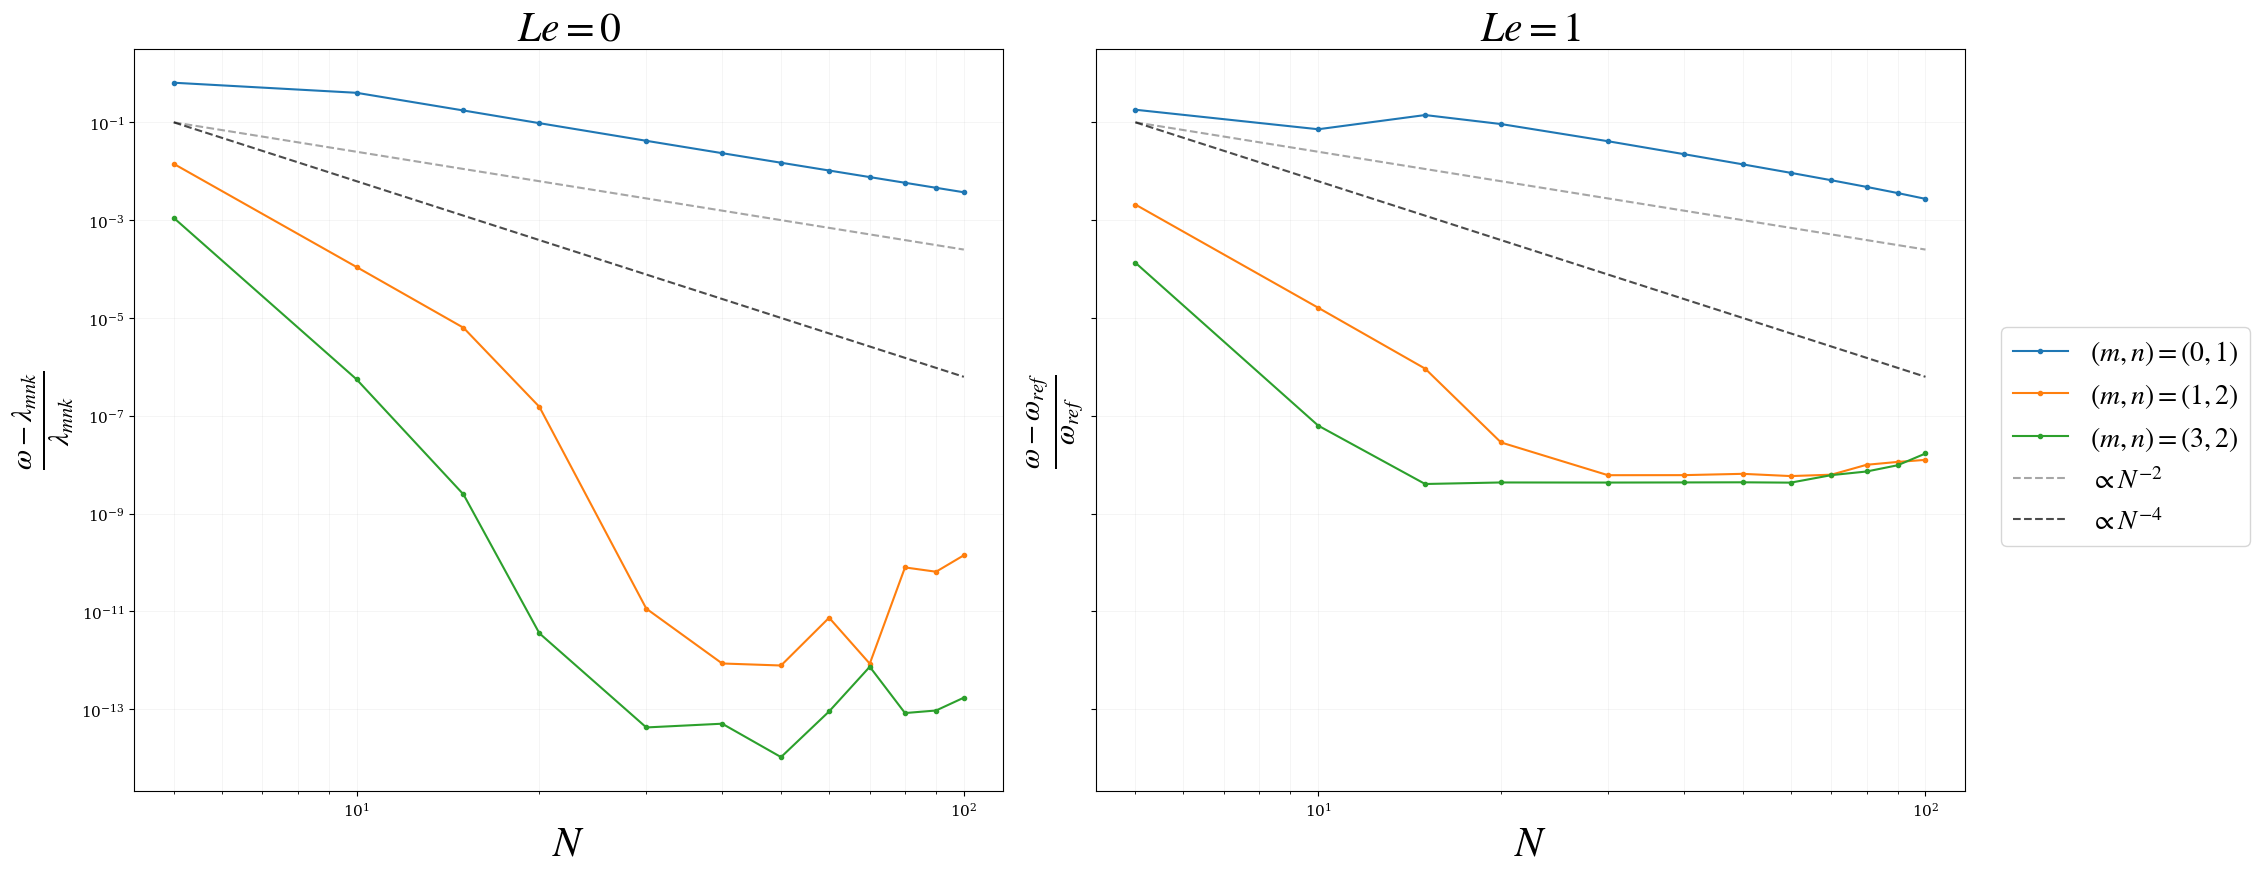

In [39]:
# === Double convergence plot (B0=0 inertial ref vs B0=1 numerical ref) ===
def convergence_double(mn_list, N_values=None, N_ref=200):
    if N_values is None:
        N_values = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    fig, axes = plt.subplots(1, 2, figsize=(20, 9), sharey=True)
    N_plot = np.array(N_values, dtype=float)

    # === LEFT: inertial analytic reference (B0=0) ===
    ax = axes[0]
    first_err = None
    for (m, n_axial) in mn_list:
        omega_ref = inertial_frequency(m, n_axial, h, a)
        errors = []
        for N in N_values:
            resN = MC_solve(m, n_axial, B0_values=[0.0], N=N, return_evec=False)
            if len(resN["omega_MC"]) == 0:
                errors.append(np.nan)
                continue
            omegaN = float(resN["omega_MC"][0])
            err = abs((omegaN - omega_ref) / omega_ref)
            errors.append(err)
        ax.loglog(N_values, errors, ".-", label=rf"$(m,n)=({m},{n_axial})$")
        if first_err is None:
            first_err = next((e for e in errors if np.isfinite(e)), 0.1)
    # slope guides (start at 0.1 for clarity)
    y0 = 0.1
    ax.loglog(N_plot, y0*(N_plot[0]/N_plot)**2, "--", color="gray", alpha=0.7, label = r"$\propto N^{-2}$")
    ax.loglog(N_plot, y0*(N_plot[0]/N_plot)**4, "--", color="black", alpha=0.7, label = r"$\propto N^{-4}$")
    ax.set_xlabel(r"$N$", fontsize = 30)
    ax.set_ylabel(r"$\frac{\omega-\lambda_{mnk}}{\lambda_{mnk}}$", fontsize = 30)
    ax.set_title(r"$Le = 0$", fontsize = 30)
    ax.grid(alpha=0.15, linewidth=0.6, which="both")

    # === RIGHT: numerical reference at B0=1 ===
    ax = axes[1]
    for (m, n_axial) in mn_list:
        ref = MC_solve(m, n_axial, B0_values=[1.0], N=N_ref, return_evec=False)
        omega_ref = ref["omega_MC"][0]
        errors = []
        for N in N_values:
            resN = MC_solve(m, n_axial, B0_values=[1.0], N=N, return_evec=False)
            omegaN = resN["omega_MC"][0]
            err = abs((omegaN - omega_ref) / omega_ref)
            errors.append(err)
        ax.loglog(N_values, errors, ".-", label=rf"$(m,n)=({m},{n_axial})$")
    # slope guides (start at 0.1 for clarity)
    y0 = 0.1
    ax.loglog(N_plot, y0*(N_plot[0]/N_plot)**2, "--", color="gray", alpha=0.7, label = r"$\propto N^{-2}$")
    ax.loglog(N_plot, y0*(N_plot[0]/N_plot)**4, "--", color="black", alpha=0.7, label = r"$\propto N^{-4}$")
    ax.set_xlabel(r"$N$", fontsize = 30)
    ax.set_ylabel(r"$\frac{\omega-\omega_{ref}}{\omega_{ref}}$", fontsize = 30)
    ax.set_title(r"$Le = 1$", fontsize = 30)
    ax.grid(alpha=0.15, linewidth=0.6, which="both")

    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, frameon=True,loc = "center left", bbox_to_anchor=(1, 0.5), fontsize = 20)
    plt.tight_layout()#rect=[0, 0, 0.85, 1])

    plt.savefig("convergence_double.png", dpi=500, bbox_inches="tight")
    plt.show()

# Call
convergence_double(
    mn_list=[(0,1),(1,2),(3,2)]
)


## Modes Plots

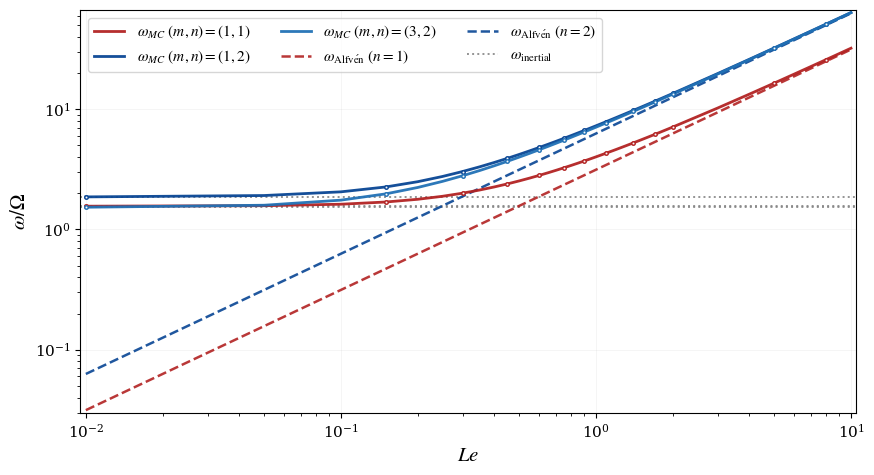

In [40]:
plt.rcParams.update({
    "text.usetex": False, "mathtext.fontset": "stix",
    "font.family": "serif", "font.size": 15,
    "axes.labelsize": 15, "axes.titlesize": 15, "legend.fontsize": 11,
    "xtick.labelsize": 11, "ytick.labelsize": 11
})

# ---colors for n ---
warm_n1 = ["#B22222", "#E6550D", "#FD8D3C", "#FEB24C", "#FED976"]
blue_n2 = ["#084594", "#2171B5", "#4292C6", "#6BAED6", "#9ECAE1"]
#green_n3 = ["#90EE90", "#76FF7B", "#7FFF00","#008000", "#15B01A"]
marker_seq = cycle([".", ".", ".", ".", "."])

fig, ax = plt.subplots(figsize=(9, 5))

res_n1 = [r for r in results if r["n"] == 1]
res_n2 = [r for r in results if r["n"] == 2]
#res_n3 = [r for r in results if r["n"] == 3]

# --- plot n=1 (warm) ---
for i, res in enumerate(res_n1):
    m, n = res["m"], res["n"]
    x, y = res["Le"], res["omega_MC"]
    color = warm_n1[i % len(warm_n1)]
    marker = next(marker_seq)

    k = max(1, len(x)//12)
    ax.plot(x, y, lw=2.0, ls="-", color=color, alpha=0.95,
            label=rf"$\omega_{{MC}} \ (m,n)=({m},{n})$", zorder=3)
    ax.plot(x[::k], y[::k], linestyle="None", marker=marker, ms=5,
            mec=color, mfc="white", mew=1.1, alpha=0.95, zorder=4)

# --- plot n=2 (cold) ---
for i, res in enumerate(res_n2):
    m, n = res["m"], res["n"]
    x, y = res["Le"], res["omega_MC"]
    color = blue_n2[i % len(blue_n2)]
    marker = next(marker_seq)

    k = max(1, len(x)//12)
    ax.plot(x, y, lw=2.0, ls="-", color=color, alpha=0.95,
            label=rf"$\omega_{{MC}} \ (m,n)=({m},{n})$", zorder=3)
    ax.plot(x[::k], y[::k], linestyle="None", marker=marker, ms=5,
            mec=color, mfc="white", mew=1.1, alpha=0.95, zorder=4)
"""
# --- plot n=3 (green) ---
for i, res in enumerate(res_n3):
    m, n = res["m"], res["n"]
    x, y = res["Le"], res["omega_MC"]
    color = green_n3[i % len(green_n3)]
    marker = next(marker_seq)

    k = max(1, len(x)//12)
    ax.plot(x, y, lw=2.0, ls="-", color=color, alpha=0.95,
            label=rf"$\omega_{{MC}} \ (m,n)=({m},{n})$", zorder=3)
    ax.plot(x[::k], y[::k], linestyle="None", marker=marker, ms=5,
            mec=color, mfc="white", mew=1.1, alpha=0.95, zorder=4)
"""   
# --- Alfvén limit : coulor by n ---
ref11 = next((r for r in results if r["m"]==1 and r["n"]==1), None)
if ref11 is not None:
    ax.plot(ref11["Le"], ref11["omega_alfven"],
            linestyle="--", lw=1.8, alpha=0.9,
            color=warm_n1[0], label=r"$\omega_{\mathrm{Alfv\acute{e}n}} \ (n=1)$",
            zorder=2)
    
ref12 = next((r for r in results if r["m"]==1 and r["n"]==2), None)
if ref12 is not None:
    ax.plot(ref12["Le"], ref12["omega_alfven"],
            linestyle="--", lw=1.8, alpha=0.9,
            color=blue_n2[0], label=r"$\omega_{\mathrm{Alfv\acute{e}n}} \ (n=2)$",
            zorder=2)
"""
ref13 = next((r for r in results if r["m"]==1 and r["n"]==3), None)
if ref11 is not None:
    ax.plot(ref11["Le"], ref11["omega_alfven"],
            linestyle="--", lw=1.8, alpha=0.9,
            color=warm_n1[0], label=r"$\omega_{\mathrm{Alfv\acute{e}n}} \ (n=3)$",
            zorder=2)
"""  
# --- Inertial limit ---
added_label = False
for res in results:
    wI = res["omega_inertial"]
    if not np.isfinite(wI):
        continue
    lbl = r"$\omega_\mathrm{inertial}$" if not added_label else None
    ax.axhline(wI, color="#888888", ls=":", lw=1.4, alpha=0.9, label=lbl, zorder=1)
    added_label = True

# --- Formatting ---
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlabel(r"$Le$")
ax.set_ylabel(r"$\omega/\Omega$")

ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=8))
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=tuple(np.arange(2,10)*0.1)))
ax.xaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=8))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=tuple(np.arange(2,10)*0.1)))
ax.yaxis.set_minor_formatter(NullFormatter())

ax.grid(alpha=0.15, linewidth=0.6)

# ---L
all_x = np.concatenate([r["Le"] for r in results])
all_y = np.concatenate([r["omega_MC"] for r in results] +
                       [ref11["omega_alfven"]] if ref11 is not None else [])
xmin, xmax = all_x.min(), all_x.max()
ymin, ymax = max(all_y.min(), 1e-8), all_y.max()
ax.set_xlim(xmin*0.95, xmax*1.05)
ax.set_ylim(ymin*0.95, ymax*1.05)

# --- Légende ---
ax.legend(ncol=3, loc="upper left", bbox_to_anchor=(0, 1), frameon=True)

fig.tight_layout()
fig.savefig("MCW_familles.png", dpi=500)
plt.show()


## v and b fields

In [41]:
def _extract_fields_from_res(res):
    """Collect T,P,G,F, la grid s, size and parameters (m,k,n_p,D) """
    if "evec_dom" not in res or res["evec_dom"] is None:
        raise ValueError("No eigenvector stored. Restart solve_family(..., return_evec=True).")

    u = res["evec_dom"]
    s = res["s"]
    n_p = res["n_p"]
    m = res["m"]
    k = res["k"]

    N_local = n_p - 1
    D_local, _ = cheb_diff(N_local, a)

    T_vec = u[0:n_p]
    P_vec = u[n_p:2*n_p]
    G_vec = u[2*n_p:3*n_p]
    F_vec = u[3*n_p:4*n_p]

    return T_vec, P_vec, G_vec, F_vec, s, n_p, m, k, D_local


def _omega_for_res(res):
    """Return the omega (complex) corresponding to the stored eigevnvector"""
    if "omega_dom" in res and res["omega_dom"] is not None:
        return res["omega_dom"]

    stored_B0 = res.get("stored_B0", None)
    if stored_B0 is not None and "B0_values" in res:
        B0_vals = np.asarray(res["B0_values"], dtype=float)
        idx = int(np.where(np.isclose(B0_vals, stored_B0))[0][0])
        # res["omega_MC"] est réel (déjà /Omega_mass), on le remonte comme réel
        return res["omega_MC"][idx] + 0j

    return complex(res["omega_MC"][0])

def calculate_velocity_components(res, t):
    """
    Return (s_grid, phi_grid, z_grid, v_s, v_phi, v_z) at time t
    for the dominant eigenvector stored in `res`.
    """
    T_vec, P_vec, G_vec, F_vec, s, n_p, m, k, D = _extract_fields_from_res(res)
    omega = _omega_for_res(res)

    phi = np.linspace(0, 2 * np.pi, n_p)
    z = np.linspace(0, h, n_p)
    s_grid, phi_grid, z_grid = np.meshgrid(s, phi, z, indexing='ij')

    exp_term = np.exp(1j * (k * z_grid + m * phi_grid + omega * t))

    P_interp = P_vec[:, np.newaxis, np.newaxis]
    T_interp = T_vec[:, np.newaxis, np.newaxis]
    D_P_vec = D @ P_vec
    D_P_interp = D_P_vec[:, np.newaxis, np.newaxis]

    S_grid = s_grid
    S2_grid = S_grid**2

    v_s = (k**2 * P_interp * S2_grid + m**2 * P_interp) * exp_term
    v_phi = (1j * k * T_interp * S2_grid + 1j * m * S_grid * D_P_interp - 1j * m * P_interp) * exp_term
    v_z = (1j * k * D_P_interp * S2_grid + 1j * k * S_grid * P_interp - 1j * m * T_interp) * exp_term

    return s_grid, phi_grid, z_grid, v_s.real, v_phi.real, v_z.real


def calculate_magnetic_components(res, t):

    T_vec, P_vec, G_vec, F_vec, s, n_p, m, k, D = _extract_fields_from_res(res)
    omega = _omega_for_res(res)

    phi = np.linspace(0, 2 * np.pi, n_p)
    z = np.linspace(0, h, n_p)
    s_grid, phi_grid, z_grid = np.meshgrid(s, phi, z, indexing='ij')

    exp_term = np.exp(1j * (k * z_grid + m * phi_grid + omega * t))

    F_interp = F_vec[:, np.newaxis, np.newaxis]
    G_interp = G_vec[:, np.newaxis, np.newaxis]
    D_F_vec = D @ F_vec
    D_F_interp = D_F_vec[:, np.newaxis, np.newaxis]

    S_grid = s_grid
    S2_grid = S_grid**2

    b_s = (k**2 * F_interp * S2_grid + m**2 * F_interp) * exp_term
    b_phi = (1j * k * G_interp * S2_grid + 1j * m * S_grid * D_F_interp - 1j * m * F_interp) * exp_term
    b_z = (1j * k * D_F_interp * S2_grid + 1j * k * S_grid * F_interp - 1j * m * G_interp) * exp_term

    return s_grid, phi_grid, z_grid, b_s.real, b_phi.real, b_z.real


## Plots

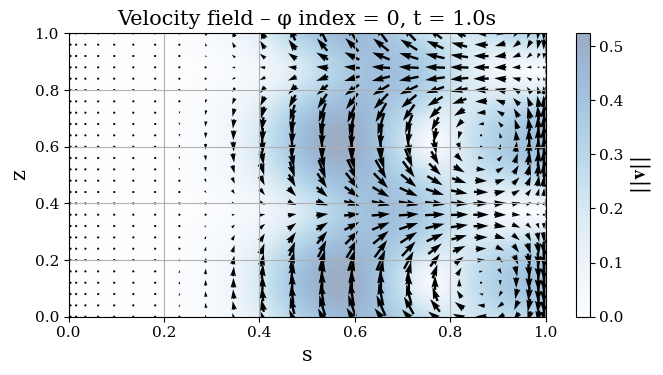

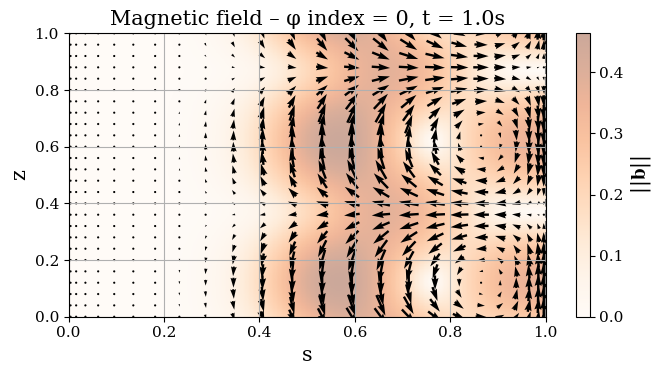

In [42]:
# ==== PARAMS ====
step = 4
res_plot = results[2]

def _get_components(res, t, kind):
    if kind == 'v':
        return calculate_velocity_components(res, t)
    elif kind == 'b':
        return calculate_magnetic_components(res, t)
    else:
        raise ValueError("kind must be 'v' or 'b' ")

def _percentile_norm(res, times, phi_indices, kind, q=95):
    mags = []
    for t in times:
        s_grid, _, _, c_s, _, c_z = _get_components(res, t, kind)
        for phi_idx in phi_indices:
            cs = c_s[:, phi_idx, :]
            cz = c_z[:, phi_idx, :]
            mags.append(np.sqrt(cs**2 + cz**2))
    flat = np.concatenate([m.ravel() for m in mags])
    return np.percentile(flat, q)

def plot_phi_slices(res, times, phi_indices, kind='v', step=4, q=95):
    """
    Plot slices (s,z) for a set of φ and time
    """
    cmap = 'Blues' if kind == 'v' else 'Oranges'
    label = r'||$\mathbf{v}$||' if kind == 'v' else r'||$\mathbf{b}$||'
    title_prefix = "Velocity field" if kind == 'v' else "Magnetic field"

    mag_max = _percentile_norm(res, times, phi_indices, kind, q=q)
    smin, smax = res["s"].min(), res["s"].max()

    for t in times:
        s_grid, phi_grid, z_grid, c_s, _, c_z = _get_components(res, t, kind)
        fig, axes = plt.subplots(1, len(phi_indices), figsize=(7, 4), squeeze=False)
        axes = axes[0]

        for i, phi_idx in enumerate(phi_indices):
            ax = axes[i]
            cs = c_s[:, phi_idx, :]
            cz = c_z[:, phi_idx, :]
            magnitude = np.sqrt(cs**2 + cz**2)

            im = ax.imshow(
                magnitude.T,
                origin='lower',
                extent=[smin, smax, 0, h],
                aspect='auto',
                cmap=cmap,
                alpha=0.4
            )
            ax.quiver(
                s_grid[:, phi_idx, :][::step, ::step],
                z_grid[:, phi_idx, :][::step, ::step],
                cs[::step, ::step],
                cz[::step, ::step],
                scale=mag_max * 20,
                pivot="middle",
                width=0.005
            )
            ax.set_xlabel("s")
            ax.set_ylabel("z")
            ax.set_title(f"{title_prefix} – φ index = {phi_idx}, t = {t:.1f}s")
            ax.axvline(1.0, color='gray', linestyle='--')
            ax.grid(True)
            fig.colorbar(im, ax=ax, label=label)

        plt.tight_layout()
        plt.show()

# ==== Call ====
plot_phi_slices(res_plot, times, phi_indices, kind='v', step=step, q=99)
plot_phi_slices(res_plot, times, phi_indices, kind='b', step=step, q=99)

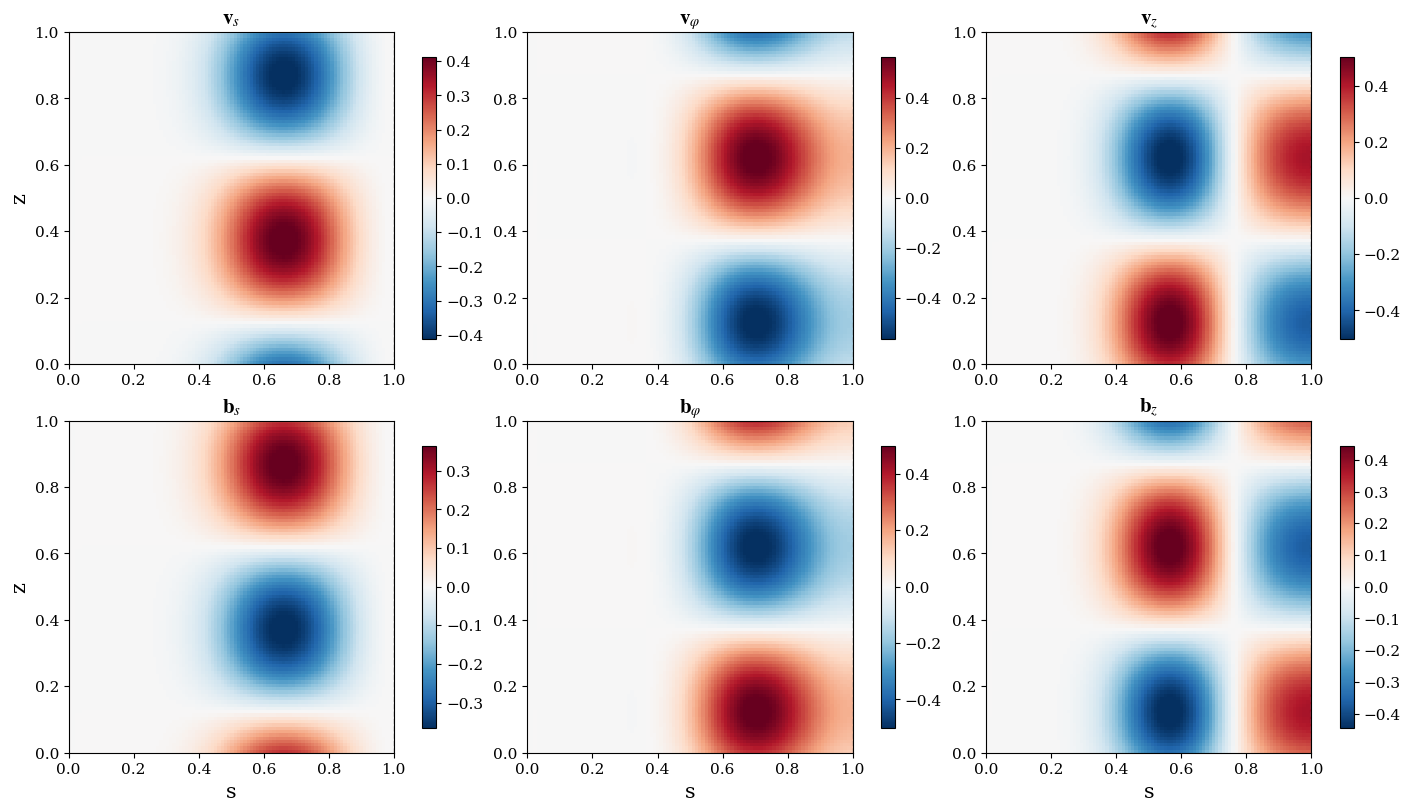

In [44]:
res_plot = results[2]
phi_idx0 = 0

def collect_component_percentiles(res, times, phi_idx, q=99):
    lims = {}
    # Vitesse
    vs_all, vphi_all, vz_all = [], [], []
    for t in times:
        _, _, _, v_s, v_phi, v_z = calculate_velocity_components(res, t)
        vs_all.append(np.abs(v_s[:, phi_idx, :]))
        vphi_all.append(np.abs(v_phi[:, phi_idx, :]))
        vz_all.append(np.abs(v_z[:, phi_idx, :]))
    lims['v_s']   = np.percentile(np.concatenate([a.ravel() for a in vs_all]),   q)
    lims['v_phi'] = np.percentile(np.concatenate([a.ravel() for a in vphi_all]), q)
    lims['v_z']   = np.percentile(np.concatenate([a.ravel() for a in vz_all]),   q)

    bs_all, bphi_all, bz_all = [], [], []
    for t in times:
        try:
            _, _, _, b_s, b_phi, b_z = calculate_magnetic_components(res, t)
        except Exception:
            n_s, n_z = res["n_p"], res["n_p"]
            b_s = np.zeros((n_s, n_z)); b_phi = np.zeros_like(b_s); b_z = np.zeros_like(b_s)
        bs_all.append(np.abs(b_s[:, phi_idx, :]))
        bphi_all.append(np.abs(b_phi[:, phi_idx, :]))
        bz_all.append(np.abs(b_z[:, phi_idx, :]))
    lims['b_s']   = np.percentile(np.concatenate([a.ravel() for a in bs_all]),   q)
    lims['b_phi'] = np.percentile(np.concatenate([a.ravel() for a in bphi_all]), q)
    lims['b_z']   = np.percentile(np.concatenate([a.ravel() for a in bz_all]),   q)
    return lims

lims = collect_component_percentiles(res_plot, times, phi_idx0, q=99)

# 6 plots (2x3) for φ = phi_idx0 at t
s_arr = res_plot["s"]
smin, smax = s_arr.min(), s_arr.max()
m_az, n_axial = res_plot["m"], res_plot["n"]

for t in times:
    _, _, _, v_s, v_phi, v_z = calculate_velocity_components(res_plot, t)
    vs   = v_s[:,   phi_idx0, :]
    vphi = v_phi[:, phi_idx0, :]
    vz   = v_z[:,   phi_idx0, :]

    try:
        _, _, _, b_s, b_phi, b_z = calculate_magnetic_components(res_plot, t)
        bs   = b_s[:,   phi_idx0, :]
        bphi = b_phi[:, phi_idx0, :]
        bz   = b_z[:,   phi_idx0, :]
    except Exception:
        n_s, n_z = vs.shape
        bs = np.zeros((n_s, n_z))
        bphi = np.zeros_like(bs)
        bz = np.zeros_like(bs)

    fig, axes = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)

    # Velocity
    imgs = []
    im0 = axes[0, 0].imshow(vs.T,   origin='lower',
                            extent=[smin, smax, 0, h],
                            aspect='auto', cmap='RdBu_r',
                            vmin=-lims['v_s'], vmax=lims['v_s'])
    axes[0, 0].set_title(r"$\mathbf{v}_s$"); imgs.append(im0)

    im1 = axes[0, 1].imshow(vphi.T, origin='lower',
                            extent=[smin, smax, 0, h],
                            aspect='auto', cmap='RdBu_r',
                            vmin=-lims['v_phi'], vmax=lims['v_phi'])
    axes[0, 1].set_title(r"$\mathbf{v}_\varphi$"); imgs.append(im1)

    im2 = axes[0, 2].imshow(vz.T,   origin='lower',
                            extent=[smin, smax, 0, h],
                            aspect='auto', cmap='RdBu_r',
                            vmin=-lims['v_z'], vmax=lims['v_z'])
    axes[0, 2].set_title(r"$\mathbf{v}_z$"); imgs.append(im2)

    # Magnetic
    im3 = axes[1, 0].imshow(bs.T,   origin='lower',
                            extent=[smin, smax, 0, h],
                            aspect='auto', cmap='RdBu_r',
                            vmin=-lims['b_s'], vmax=lims['b_s'])
    axes[1, 0].set_title(r"$\mathbf{b}_s$"); imgs.append(im3)

    im4 = axes[1, 1].imshow(bphi.T, origin='lower',
                            extent=[smin, smax, 0, h],
                            aspect='auto', cmap='RdBu_r',
                            vmin=-lims['b_phi'], vmax=lims['b_phi'])
    axes[1, 1].set_title(r"$\mathbf{b}_\varphi$"); imgs.append(im4)

    im5 = axes[1, 2].imshow(bz.T,   origin='lower',
                            extent=[smin, smax, 0, h],
                            aspect='auto', cmap='RdBu_r',
                            vmin=-lims['b_z'], vmax=lims['b_z'])
    axes[1, 2].set_title(r"$\mathbf{b}_z$"); imgs.append(im5)

    for i in range(2):
        for j in range(3):
            ax = axes[i, j]
            if i == 1:
                ax.set_xlabel("s")
            if j == 0:
                ax.set_ylabel("z")
            ax.axvline(1.0, color='gray', linestyle='--', linewidth=1)
            ax.grid(False)

    # Colorbars
    for ax, im in zip(axes.ravel(), imgs):
        fig.colorbar(im, ax=ax, shrink=0.85)

    plt.savefig(f"vb_sphiz_({m_az},{n_axial})_t{t:.2f}.png", dpi=500)
    plt.show()

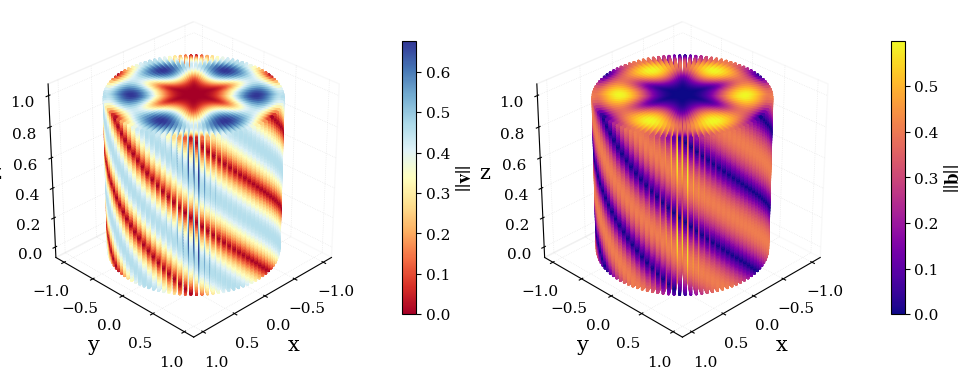

In [45]:
t = 1.0
res_plot = results[2]
Omega_bg = 0.0

s_grid, phi_grid, z_grid, v_s, v_phi, v_z = calculate_velocity_components(res_plot, t)
if Omega_bg != 0.0:
    v_phi = v_phi + Omega_bg * s_grid

try:
    _, _, _, b_s, b_phi, b_z = calculate_magnetic_components(res_plot, t)
except Exception:
    b_s = np.zeros_like(v_s)
    b_phi = np.zeros_like(v_phi)
    b_z = np.zeros_like(v_z)

# cartesian coordinates
x = s_grid * np.cos(phi_grid)
y = s_grid * np.sin(phi_grid)
z = z_grid

V_x = v_s * np.cos(phi_grid) - v_phi * np.sin(phi_grid)
V_y = v_s * np.sin(phi_grid) + v_phi * np.cos(phi_grid)
V_z = v_z

B_x = b_s * np.cos(phi_grid) - b_phi * np.sin(phi_grid)
B_y = b_s * np.sin(phi_grid) + b_phi * np.cos(phi_grid)
B_z = b_z

V_norm = np.sqrt(V_x**2 + V_y**2 + V_z**2)
B_norm = np.sqrt(B_x**2 + B_y**2 + B_z**2)

# ----- figure -----
fig = plt.figure(figsize=(10, 5))

# Subplot 1 : velocity
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(x, y, z, c=V_norm, cmap='RdYlBu', s=1, alpha=1)
#ax1.set_title(r"$\mathbf{v}$")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
ax1.set_box_aspect([1, 1, 1])
ax1.view_init(elev=30, azim=45)
ax1.set_facecolor("white")
for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
    axis.pane.set_facecolor((1,1,1,1))
    axis._axinfo["grid"]["color"]     = (0.8, 0.8, 0.8, 0.5)
    axis._axinfo["grid"]["linewidth"] = 0.5
    axis._axinfo["grid"]["linestyle"] = ":"
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.6, pad=0.1)
cbar1.set_label(r"$||\mathbf{v}||$")

# Subplot 2 : magnetic
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(x, y, z, c=B_norm, cmap='plasma', s=1, alpha=1)
#ax2.set_title(r"$\mathbf{b}$")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
ax2.set_box_aspect([1, 1, 1])
ax2.view_init(elev=30, azim=45)
ax2.set_facecolor("white")
for axis in [ax2.xaxis, ax2.yaxis, ax2.zaxis]:
    axis.pane.set_facecolor((1,1,1,1))
    axis._axinfo["grid"]["color"]     = (0.8, 0.8, 0.8, 0.5)
    axis._axinfo["grid"]["linewidth"] = 0.5
    axis._axinfo["grid"]["linestyle"] = ":"
cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.6, pad=0.1)
cbar2.set_label(r"$||\mathbf{b}||$")

plt.tight_layout()
plt.show()
